В рамках проекта стояла проблема поиска и предобработки данных и выявление мошеннических транзакций. Данные были взяты отсюда: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud потому что на мой взгляд это наиболее близкий к реальному датасет. 
План решения состоит из следующих шагов:

1) Сбор и предварительный анализ данных

2) Выявление и удаление аномалий

3) Решение вопроса дисбаланса данных в датасете

4) Поиск лучшего алгоритма классификации

5) Исследование ансамблей для достижения лучшего качества

6) Тестирование лучших алгоритмов на данных с алгоритмами синтезирования данных

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import BaggingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from scipy.stats import norm

from google.colab import drive 

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Очевидна проблема сильного дисбаланса классов

Text(0.5, 1.0, 'Classes \n (0: Not Fraud or 1: Fraud)')

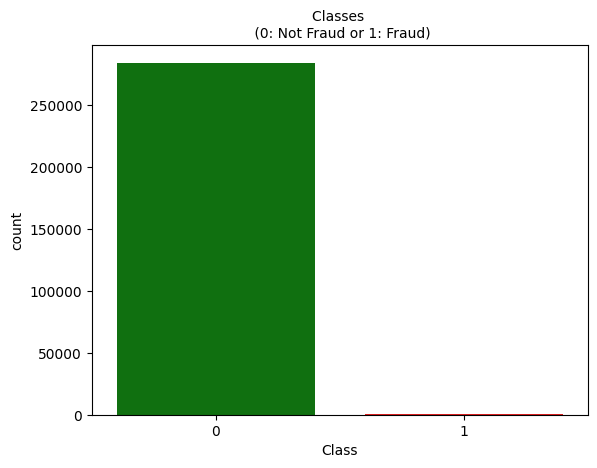

In [5]:
colors = ["green", "red"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Classes \n (0: Not Fraud or 1: Fraud)', fontsize=10)


Масштабируем данные

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [7]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Решаем проблему дисбаланса для обучения алгоритмов. Для начала просто создадим выборку с равным содержанием классов 

In [8]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
64737,0.209600,-0.392462,1.510386,-0.929858,0.240695,-1.432346,-1.206288,-0.704674,-0.791128,-0.307228,...,-0.173272,-0.216397,-0.209191,-0.064852,-0.097318,0.493676,-0.182563,0.034315,0.023059,0
6899,-0.293440,-0.890682,-2.661802,5.856393,-7.653616,6.379742,-0.060712,-3.131550,-3.103570,1.778492,...,0.399097,0.734775,-0.435901,-0.384766,-0.286016,1.007934,0.413196,0.280284,0.303937,1
11158,-0.270104,-0.767960,-0.442487,1.289264,1.782040,1.202763,-0.242006,-0.843543,0.519311,-0.371493,...,0.219749,-0.397573,-0.757737,0.019546,0.577343,-0.623177,0.212147,-0.112359,-0.024295,0
42856,2.110948,-0.510098,-11.682215,6.332882,-13.297109,7.690772,-10.889891,-2.792360,-12.561783,7.287122,...,-1.009320,2.133456,-1.271509,-0.035304,0.615054,0.349024,-0.428923,-0.694935,-0.818970,1
154676,-0.275554,0.209706,-1.456876,3.740306,-7.404518,7.440964,-1.549878,-1.661697,-5.757213,1.615011,...,0.529557,0.957897,0.145339,-0.044704,-0.544962,-0.757757,-0.005352,0.318152,-0.323554,1


Анализируем матрицы корреляций на сбалансированной и несбалансированной выборке

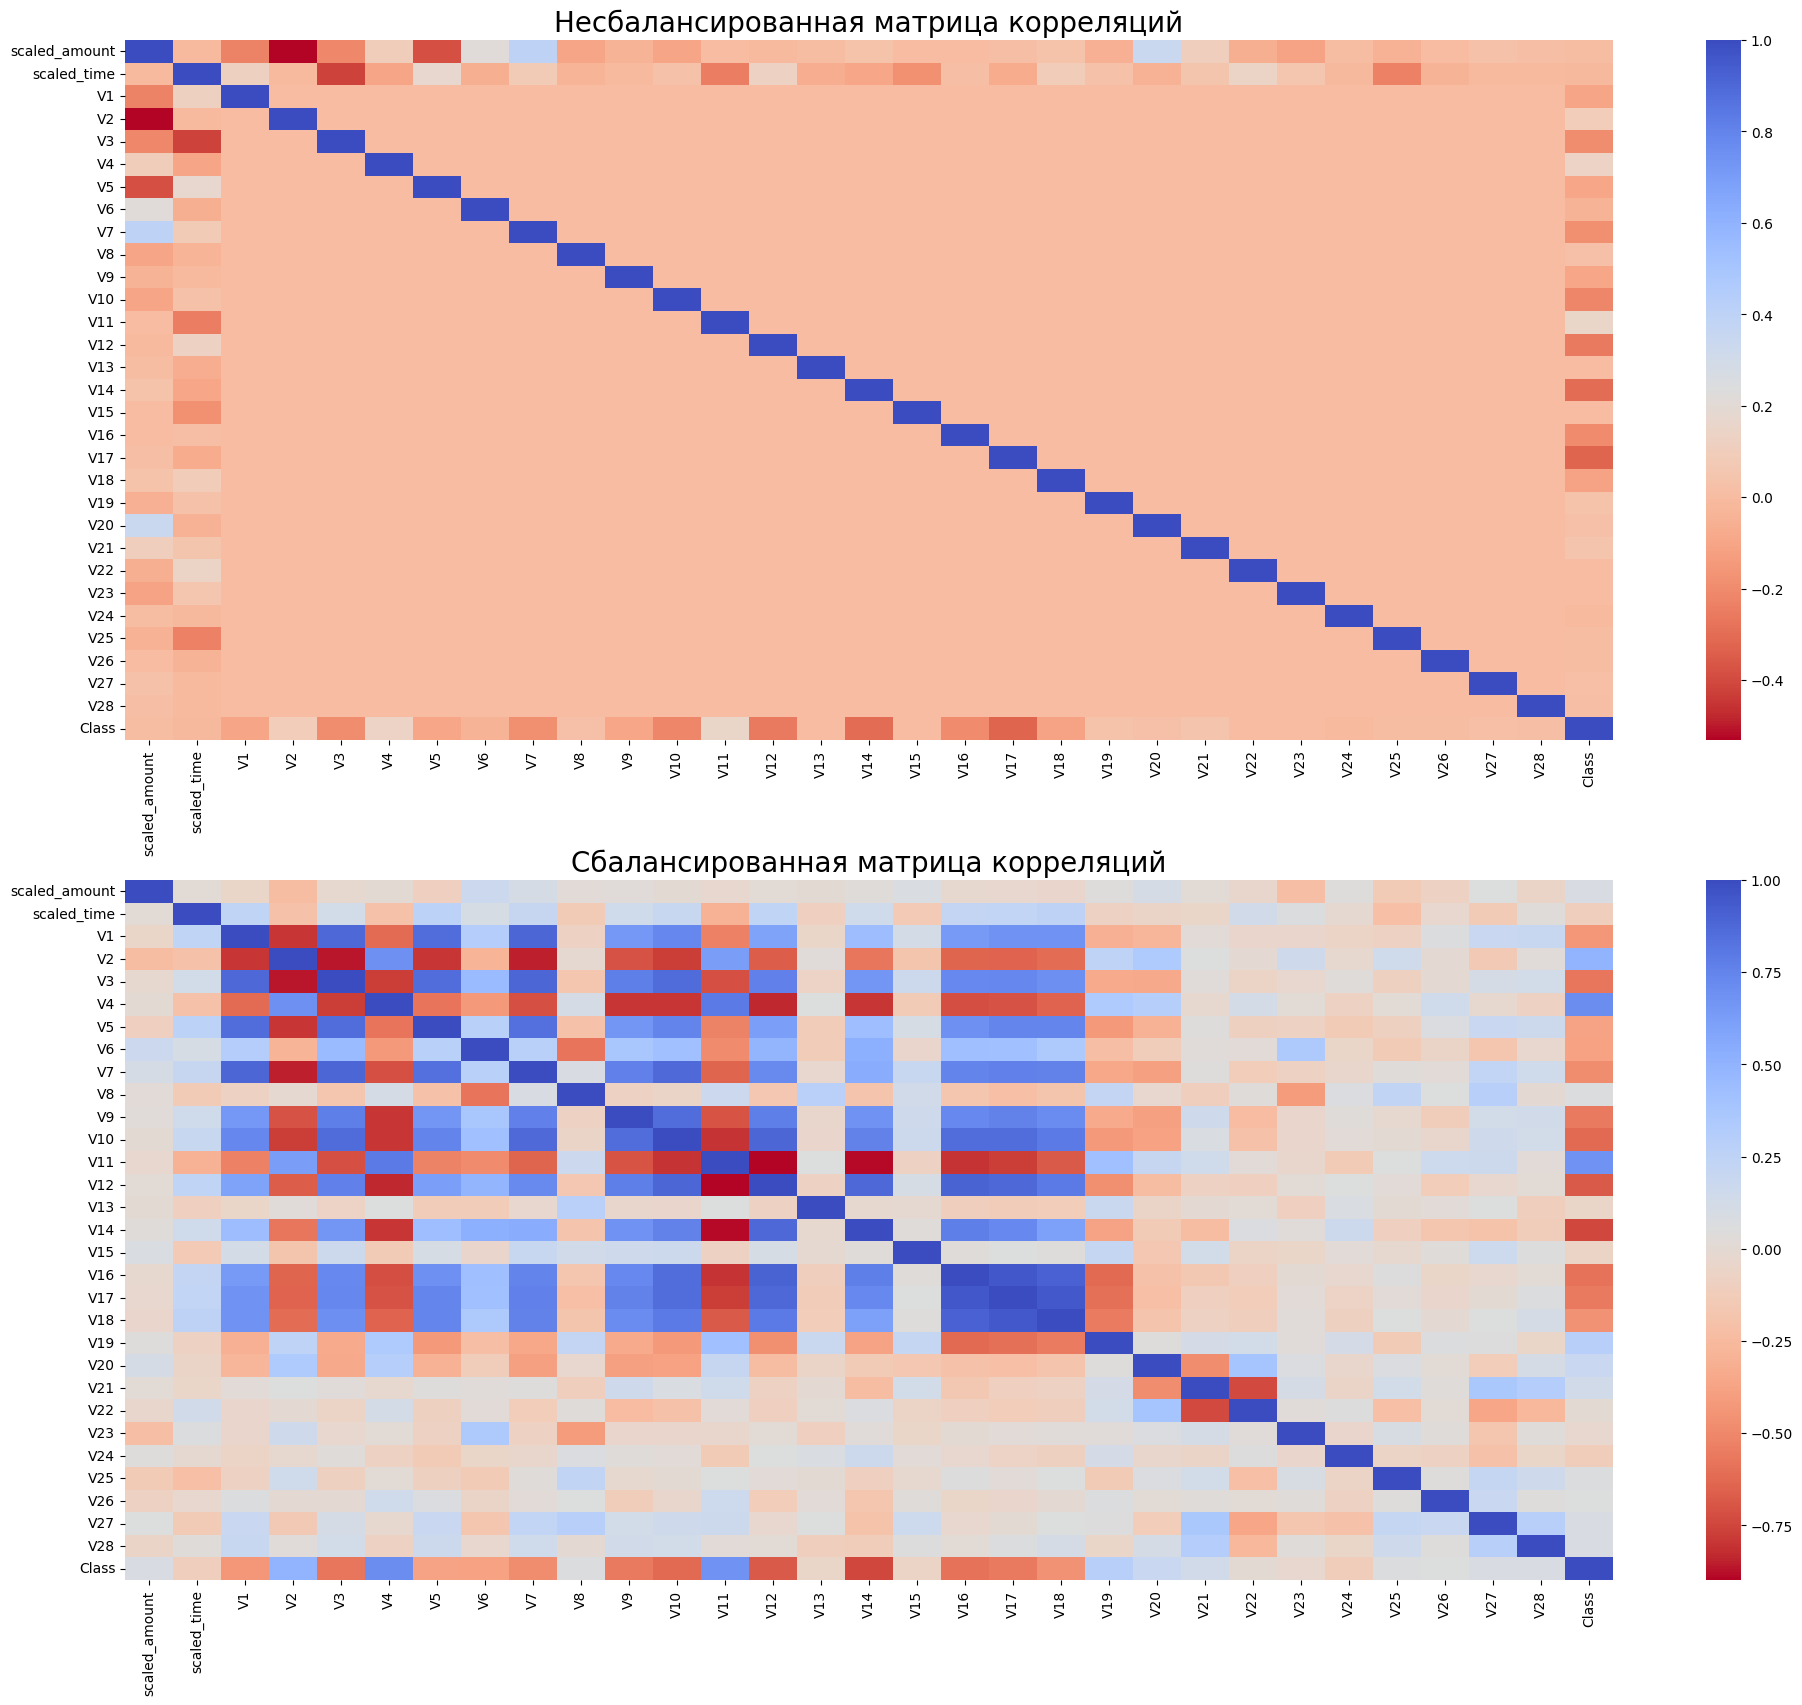

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Несбалансированная матрица корреляций", fontsize=20)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Сбалансированная матрица корреляций', fontsize=20)
plt.show()

Отрицательные корреляции с V17, V14, V12, V10 и положительные с V2, V4, V11, V19

Изучим отрицательные корреляции

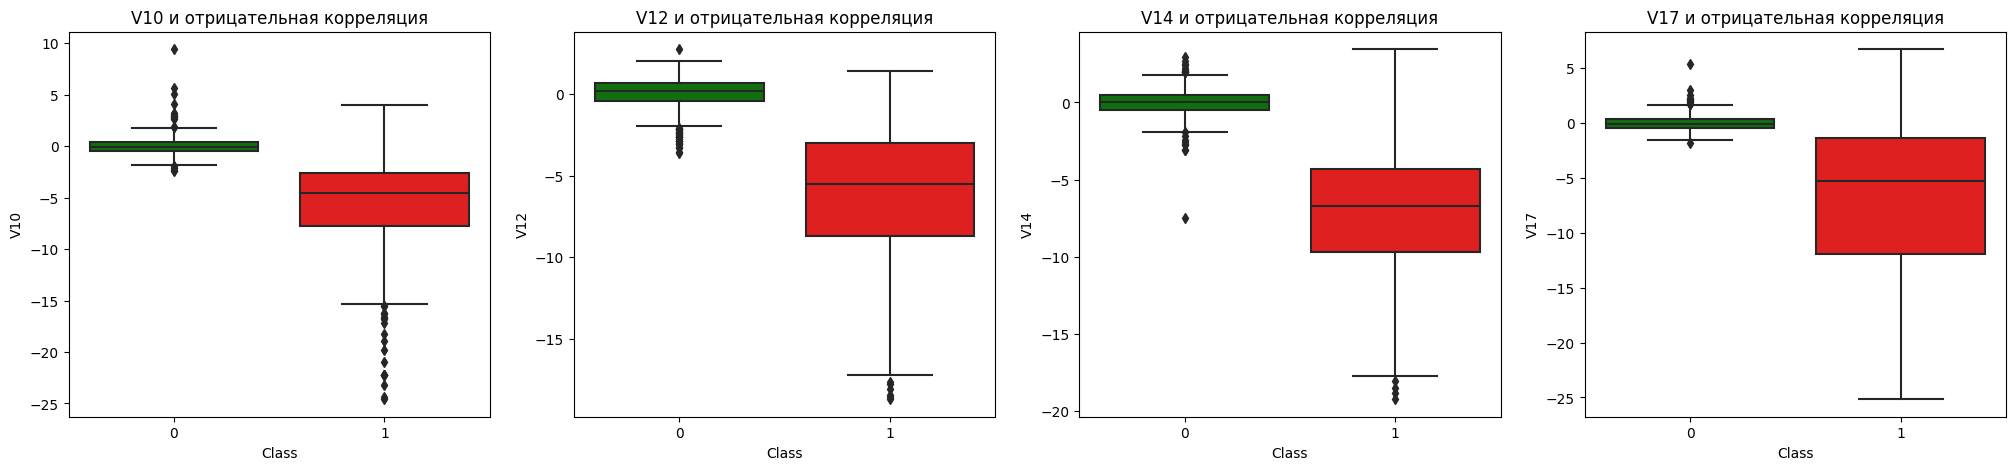

In [10]:
f, axes = plt.subplots(ncols=4, figsize=(25,5))

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 и отрицательная корреляция')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 и отрицательная корреляция')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 и отрицательная корреляция')

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V17 и отрицательная корреляция')

plt.show()


Изучим положительные корреляции

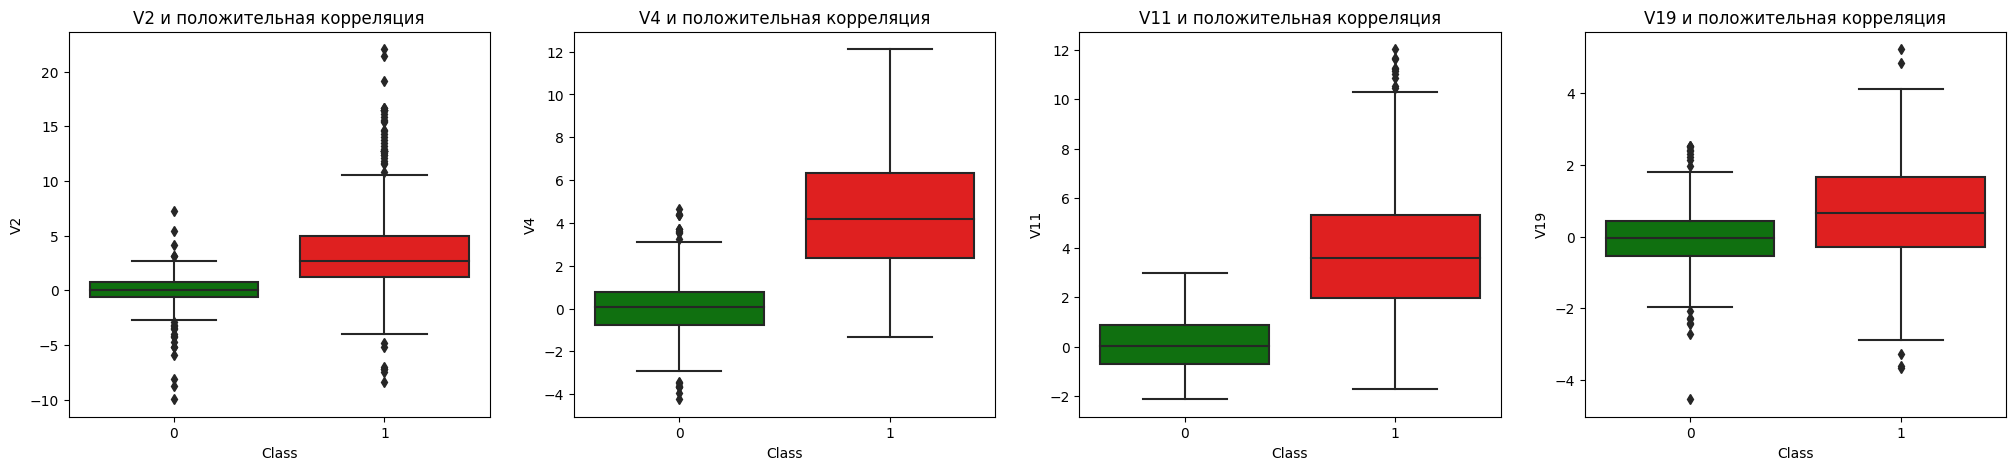

In [11]:
f, axes = plt.subplots(ncols=4, figsize=(25,5))

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 и положительная корреляция')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 и положительная корреляция')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 и положительная корреляция')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 и положительная корреляция')

plt.show()

<ipython-input-12-320c19805474>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v10_dist,ax=ax1, fit=norm, color='red')
<ipython-input-12-320c19805474>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v12_dist,ax=ax2, fit=norm, color='green')
<ipython-input-12-320c19805474>:12: UserWarning: 

`

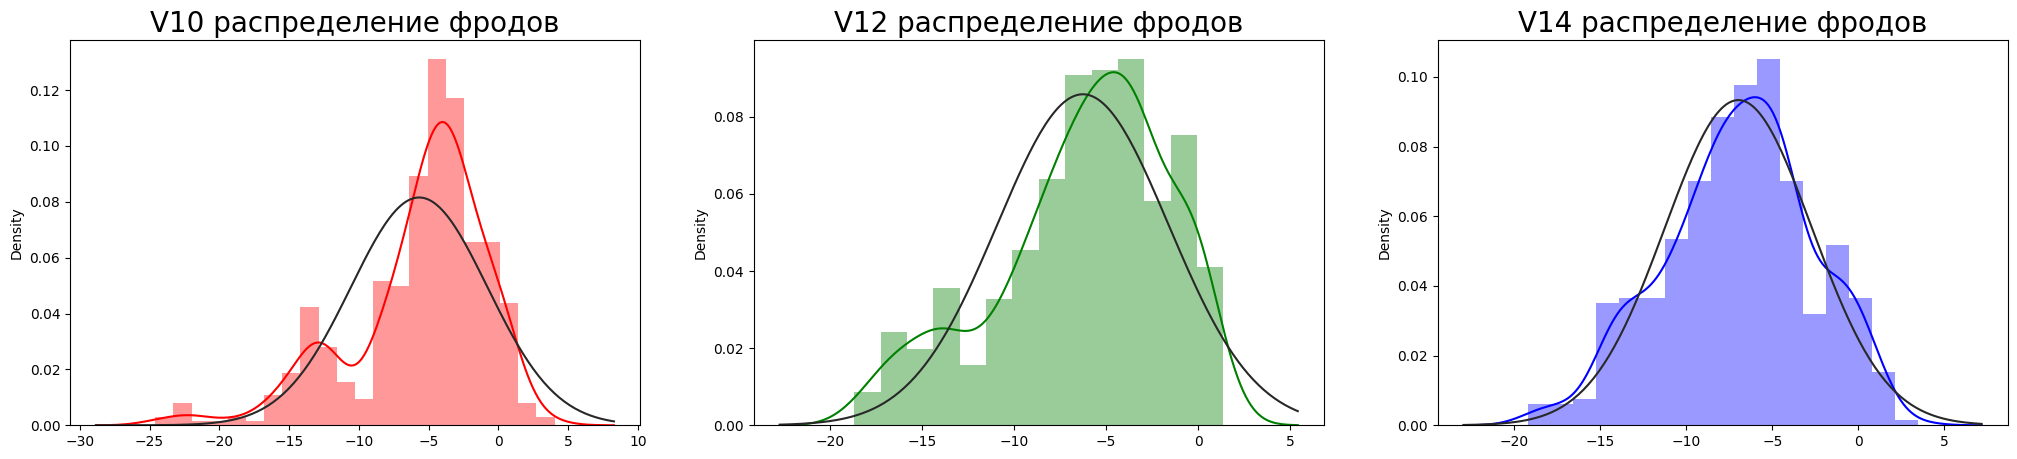

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 5))

v10_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_dist,ax=ax1, fit=norm, color='red')
ax1.set_title('V10 распределение фродов', fontsize=20)

v12_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_dist,ax=ax2, fit=norm, color='green')
ax2.set_title('V12 распределение фродов', fontsize=20)

v14_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_dist,ax=ax3, fit=norm, color='blue')
ax3.set_title('V14 распределение фродов', fontsize=20)

plt.show()

Заметим, что близкое к гауссову распределению имеет только V14

Применим IQR метод для избавления от выбросов

In [13]:
v10_is_f = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_is_f, 25), np.percentile(v10_is_f, 75)
v10_iqr = q75 - q25

v10_cut = v10_iqr * 1.5
v10_low, v10_upp = q25 - v10_cut, q75 + v10_cut
print('V10 выше положеного: {}'.format(v10_low))
print('V10 ниже положеного: {}'.format(v10_upp))
outlier = [x for x in v10_is_f if x < v10_low or x > v10_upp]
print('V10 выбросы: {}'.format(outlier))
print('V10 выбросы во фроде: {}'.format(len(outlier)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upp) | (new_df['V10'] < v10_low)].index)


V10 выше положеного: -15.47046969983434
V10 ниже положеного: 5.099587558797303
V10 выбросы: [-20.9491915543611, -18.2711681738888, -16.2556117491401, -22.1870885620007, -16.6011969664137, -23.2282548357516, -16.3035376590131, -18.9132433348732, -24.5882624372475, -24.4031849699728, -15.5637913387301, -19.836148851696, -17.1415136412892, -22.1870885620007, -22.1870885620007, -16.7460441053944, -16.6496281595399, -22.1870885620007, -15.5637913387301]
V10 выбросы во фроде: 19


In [14]:
v12_is_f = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_is_f, 25), np.percentile(v12_is_f, 75)
v12_iqr = q75 - q25

v12_cut = v12_iqr * 1.5
v12_low, v12_upp = q25 - v12_cut, q75 + v12_cut
print('V12 выше положеного: {}'.format(v12_low))
print('V12 ниже положеного: {}'.format(v12_upp))
outlier = [x for x in v12_is_f if x < v12_low or x > v12_upp]
print('V12 выбросы: {}'.format(outlier))
print('V12 выбросы во фроде: {}'.format(len(outlier)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upp) | (new_df['V12'] < v12_low)].index)

V12 выше положеного: -16.922496886663865
V12 ниже положеного: 5.633585132371216
V12 выбросы: [-17.1829184301947, -17.1313009454468, -17.003289445516, -17.1829184301947, -17.2286622386187, -18.0475965708216, -18.6837146333443, -17.1504052507291, -17.6316063138707, -18.5536970096458, -17.7691434633638, -17.003289445516, -18.4311310279993]
V12 выбросы во фроде: 13


In [15]:
v14_is_f = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_is_f, 25), np.percentile(v14_is_f, 75)
v14_iqr = q75 - q25

v14_cut = v14_iqr * 1.5
v14_low, v14_upp = q25 - v14_cut, q75 + v14_cut
print('V14 выше положеного: {}'.format(v14_low))
print('V14 ниже положеного: {}'.format(v14_upp))

outlier = [x for x in v14_is_f if x < v14_low or x > v14_upp]
print('V14 выбросы во фроде: {}'.format(len(outlier)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upp) | (new_df['V14'] < v14_low)].index)

V14 выше положеного: -17.101993690511843
V14 ниже положеного: 3.3988933645677344
V14 выбросы во фроде: 5


Теперь посмотрим на распределение наших признаков в уменьшенной размерности

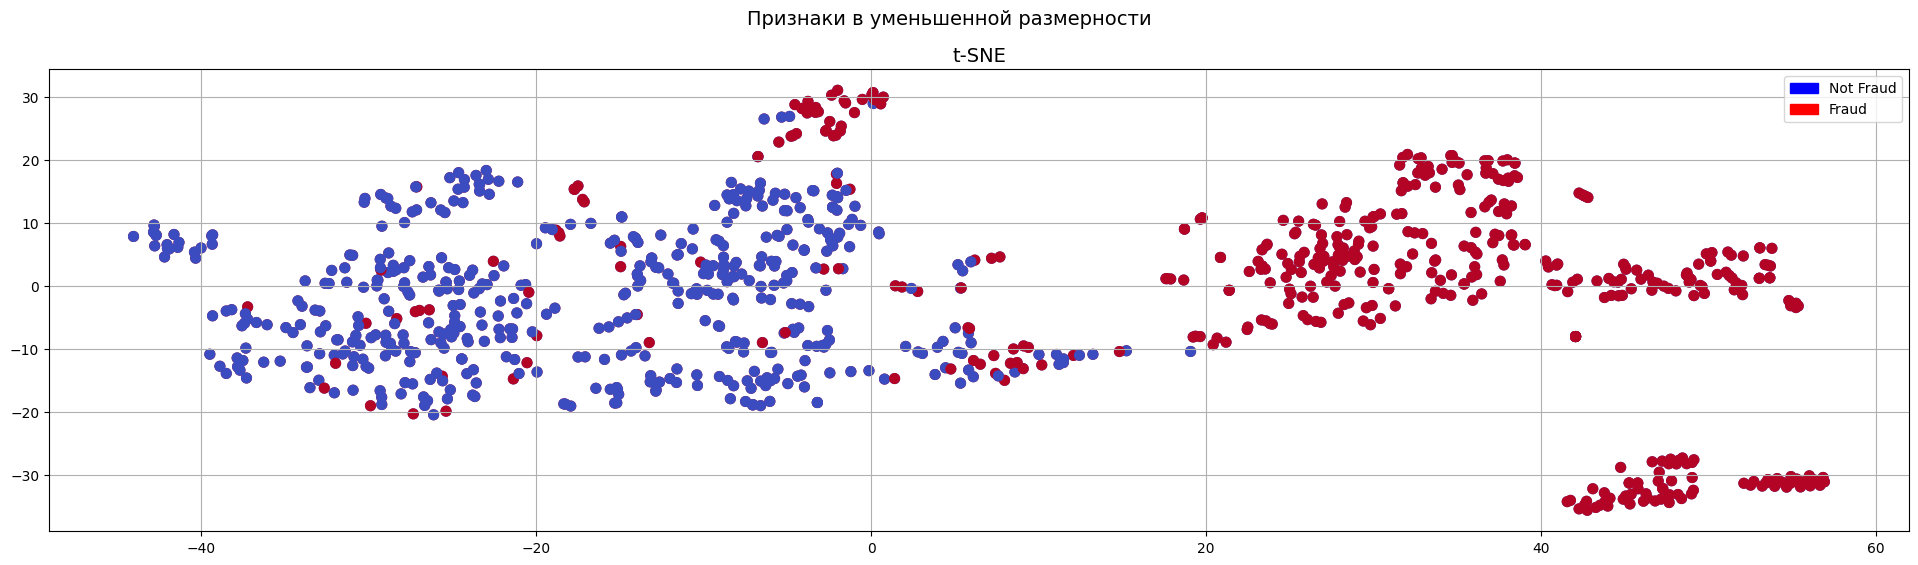

In [16]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

f, (ax) = plt.subplots(figsize=(24,6))
f.suptitle('Признаки в уменьшенной размерности', fontsize=14)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

blue_not_fraud = Patch(color='blue', label='Not Fraud')
red_is_fraud = Patch(color='red', label='Fraud')

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_not_fraud , red_is_fraud])


Теперь мы можем переходить к поиску лучшего алгоритма классификации. Опытным путем достойно справились алгоритмы, описанные ниже.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
params = {"penalty": ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 7, 10]}

logistic = make_pipeline(GridSearchCV(LogisticRegression(),
                                      param_grid=params
                                      ))

logistic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 3,
                                                5, 7, 10],
                                          'penalty': ['l1', 'l2']}))])

In [19]:
logistic.named_steps['gridsearchcv'].best_params_

{'C': 0.1, 'penalty': 'l2'}

In [20]:
print("Accuracy:", accuracy_score(logistic.predict(X_test), y_test))
print("Presicion:", precision_score(logistic.predict(X_test), y_test))
print("Recall:", recall_score(logistic.predict(X_test), y_test))
print("ROC_AUC:", roc_auc_score(logistic.predict(X_test), y_test))

Accuracy: 0.9401408450704225
Presicion: 0.9066666666666666
Recall: 0.9784172661870504
ROC_AUC: 0.9409327710245597


Логистическая регрессия давала стабильно качественный результат по выбранным метрикам (0.9+) по каждой

In [21]:
log = cross_val_predict(logistic, X_train, y_train, cv=5, method="decision_function")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

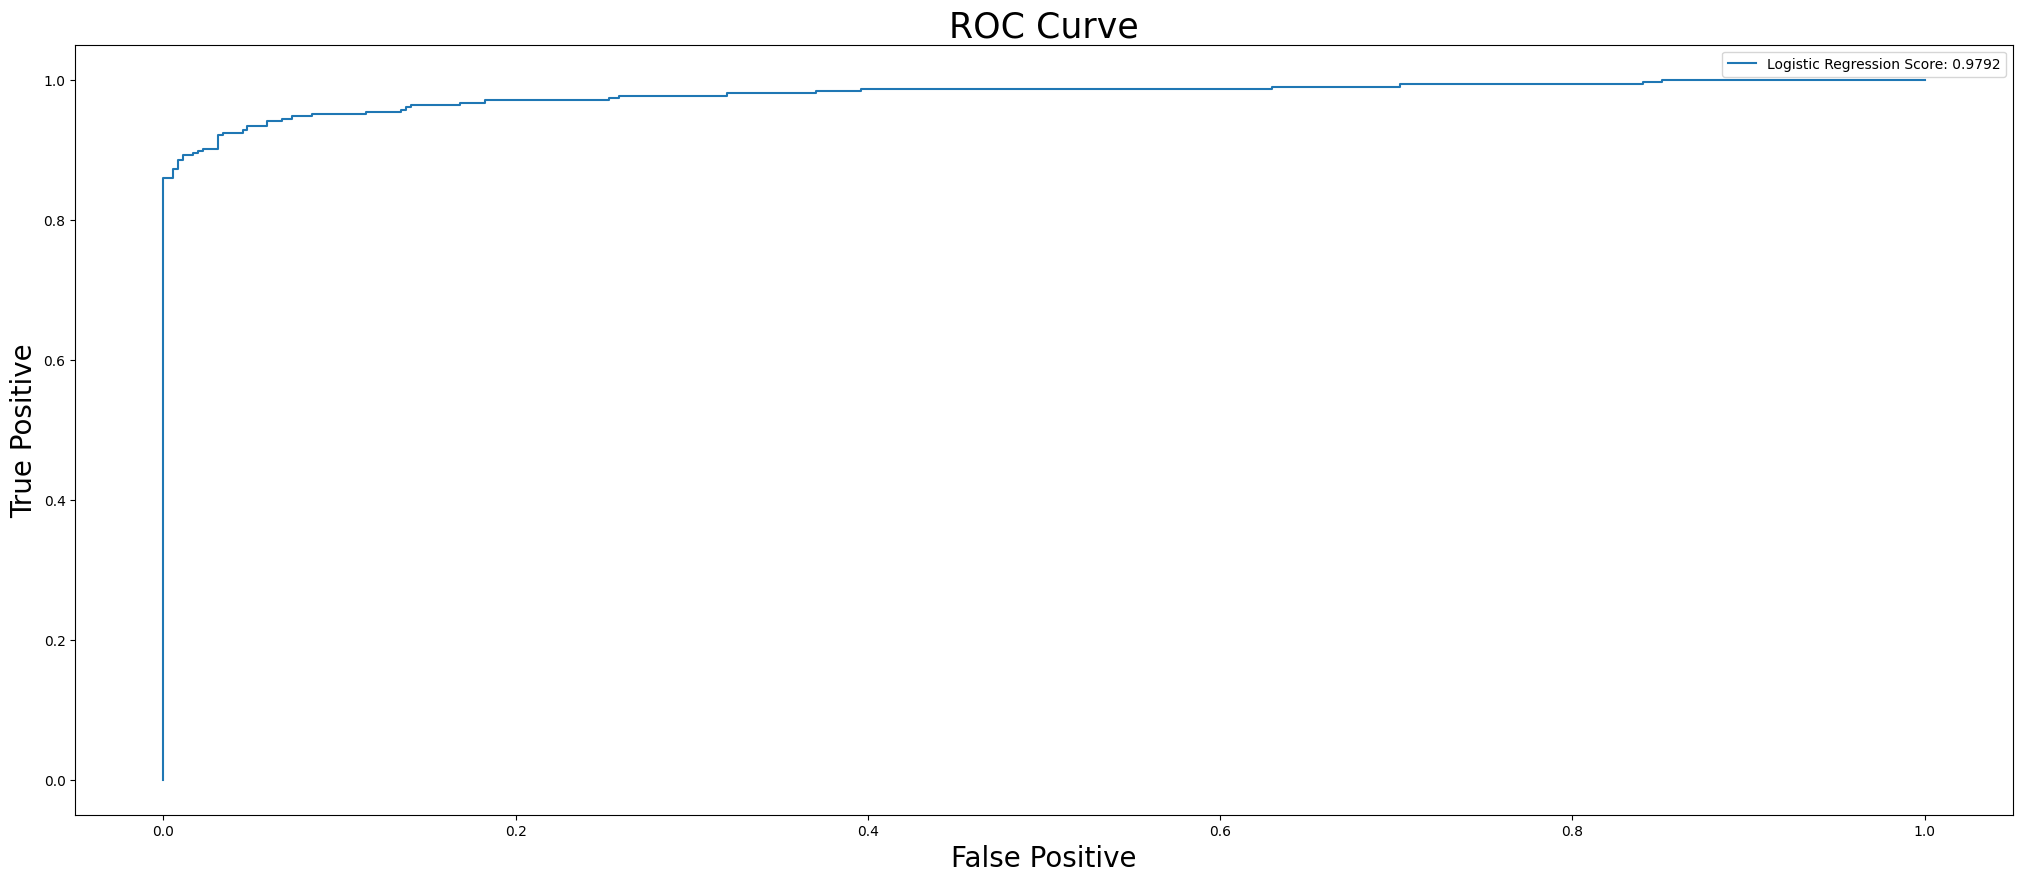

In [22]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log)
plt.figure(figsize=(25,10))
plt.title('ROC Curve', fontsize=25)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Score: {:.4f}'.format(roc_auc_score(y_train, log)))
plt.xlabel('False Positive', fontsize=20)
plt.ylabel('True Positive', fontsize=20)

plt.legend()

Действительно, рок аук кривая для логистической регрессии весьма хороша

Пробуем бустинг XGBClassifier

In [23]:
params = {
    'learning_rate': [0.01, 0.1, 1,], 
    'max_depth': [5, 10, 15],
    'subsample': [0.3, 0.5, 0.7, 0.9],
}

skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc') 

model_Xg = make_pipeline(GridSearchCV(xgb_classifier, 
                        param_grid=params, 
                        scoring='roc_auc', 
                        cv=skf, 
                        n_jobs=-1, 
                        verbose=1, 
                        return_train_score=True))


model_Xg.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      feature_types=None,
                                                      gamma=None, gpu_id=...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01, 0.1, 1],
                                          'max_depth': [5, 10, 15],
                                          'subsample': [0.3, 0.5, 0.7, 0.9]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=1))])

In [24]:
best_params = model_Xg.named_steps['gridsearchcv'].best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 10, 'subsample': 0.3}


{'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}

In [25]:
print("Accuracy:", accuracy_score(model_Xg.predict(X_test), y_test))
print("Presicion:", precision_score(model_Xg.predict(X_test), y_test))
print("Recall:", recall_score(model_Xg.predict(X_test), y_test))
print("ROC_AUC:", roc_auc_score(model_Xg.predict(X_test), y_test))

Accuracy: 0.9366197183098591
Presicion: 0.9
Recall: 0.9782608695652174
ROC_AUC: 0.9377605717689101


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits


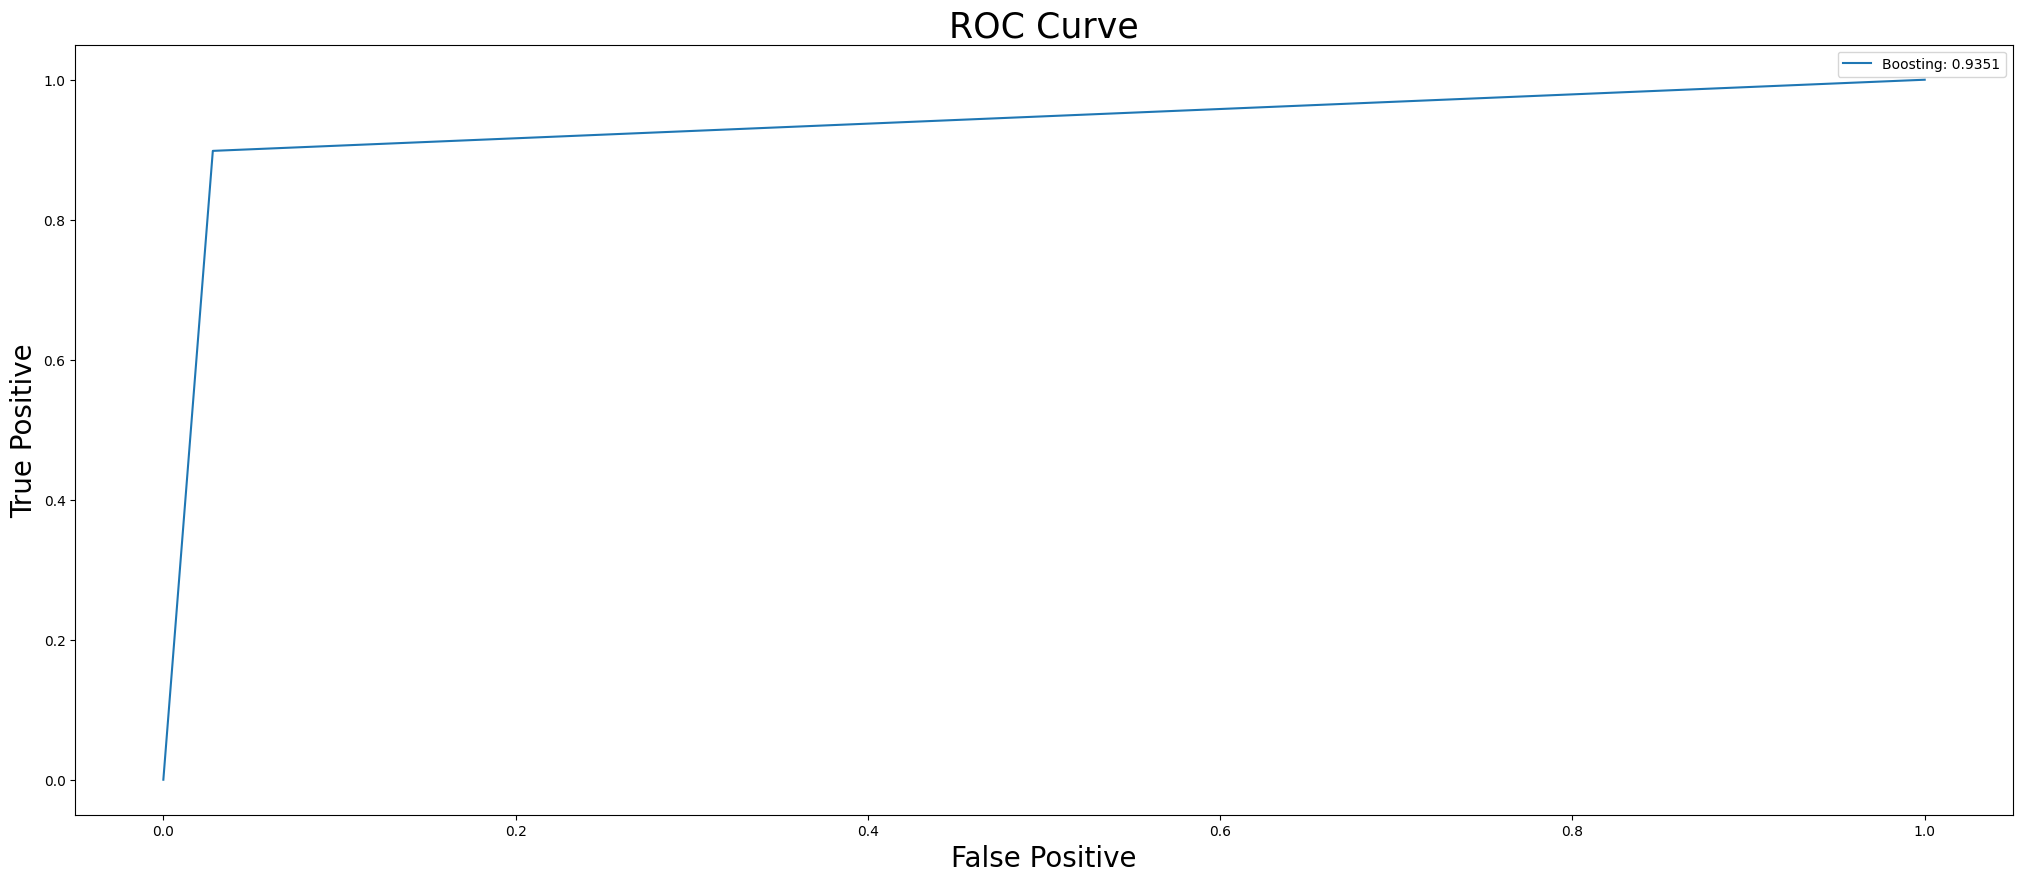

In [26]:
log_xg = cross_val_predict(model_Xg, X_train, y_train, cv=5)
log_fpr_xg, log_tpr_xg, log_thresold_xg = roc_curve(y_train, log_xg)
plt.figure(figsize=(25,10))
plt.title('ROC Curve', fontsize=25)
plt.plot(log_fpr_xg, log_tpr_xg, label='Boosting: {:.4f}'.format(roc_auc_score(y_train, log_xg)))
plt.xlabel('False Positive', fontsize=20)
plt.ylabel('True Positive', fontsize=20)

plt.legend()

In [27]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestClassifier(random_state=42)

bagging = make_pipeline(GridSearchCV(rf, 
                        param_grid=params,
                        scoring='roc_auc', 
                        cv=3, 
                        verbose=1,
                        n_jobs=-1))

bagging.fit(X_train, y_train)


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [5, 10, 15],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 200]},
                              scoring='roc_auc'))])

In [28]:
best_params = bagging.named_steps['gridsearchcv'].best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 15,
 'min_samples_split': 2,
 'n_estimators': 100}

In [29]:
print("Accuracy:", accuracy_score(bagging.predict(X_test), y_test))
print("Presicion:", precision_score(bagging.predict(X_test), y_test))
print("Recall:", recall_score(bagging.predict(X_test), y_test))
print("ROC_AUC:", roc_auc_score(bagging.predict(X_test), y_test))

Accuracy: 0.9225352112676056
Presicion: 0.8733333333333333
Recall: 0.9776119402985075
ROC_AUC: 0.9254726368159204


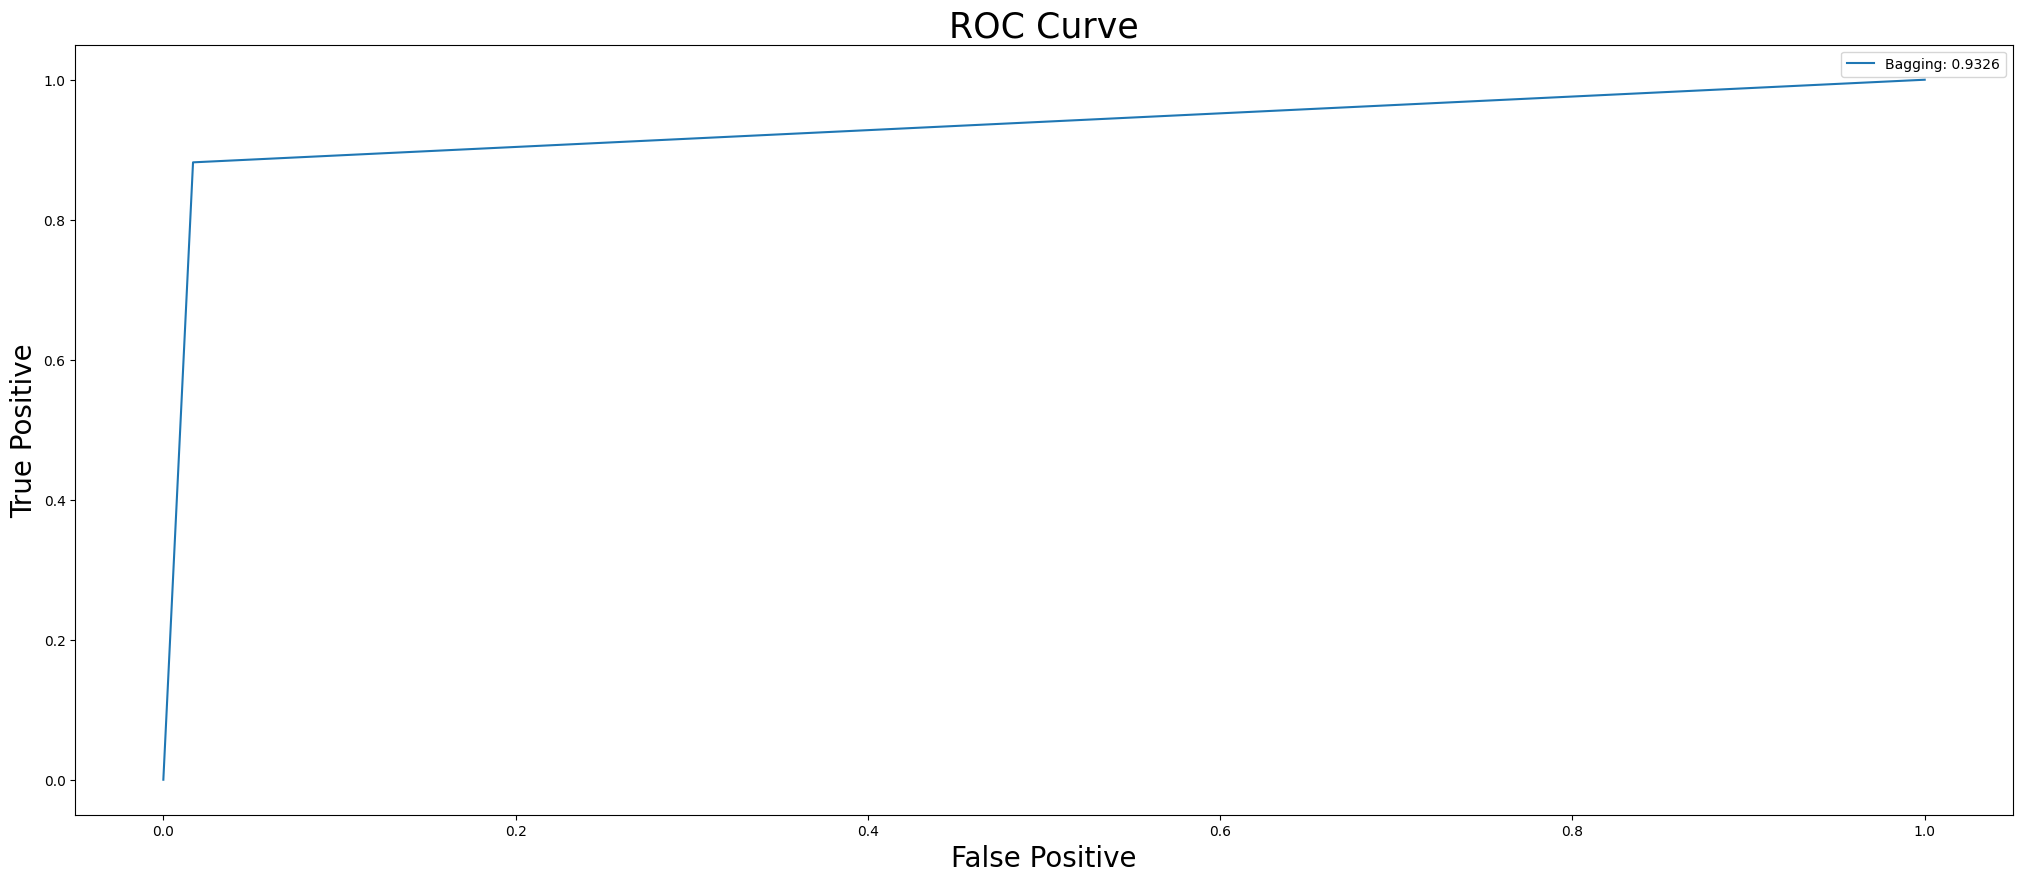

In [30]:
log_bg = cross_val_predict(bagging, X_train, y_train, cv=5)
log_fpr_bg, log_tpr_bg, log_thresold_bg = roc_curve(y_train, log_bg)
plt.figure(figsize=(25,10))
plt.title('ROC Curve', fontsize=25)
plt.plot(log_fpr_bg, log_tpr_bg, label='Bagging: {:.4f}'.format(roc_auc_score(y_train, log_bg)))
plt.xlabel('False Positive', fontsize=20)
plt.ylabel('True Positive', fontsize=20)

plt.legend()

Попробуем блендинг. В среднем в ряде опытов качетсво блендинга из сильнейших моделей - логистической регрессии, бустинга и бэггинга было лучше, чем каждой модели по отдельности. 

In [31]:
blending_pred = (logistic.predict(X_test) + model_Xg.predict(X_test) + bagging.predict(X_test))/3

In [32]:
blending_binary_pred = np.array([1 if pred >= 0.5 else 0 for pred in blending_pred]).reshape(-1, 1)

In [33]:
print("Accuracy:", accuracy_score(blending_binary_pred, y_test))
print("Presicion:", precision_score(blending_binary_pred, y_test))
print("Recall:", recall_score(blending_binary_pred, y_test))
print("ROC_AUC:", roc_auc_score(blending_binary_pred, y_test))

Accuracy: 0.9366197183098591
Presicion: 0.9
Recall: 0.9782608695652174
ROC_AUC: 0.9377605717689101


Модели отобраны, в качестве итогового ответа выбран блендинг на предсказаниях некоррелирующих моделей: логистической регрессии, бустинга, бэггинга(при малых изменениях кода можно предсказывать вероятность фрод-транзакции, но на мой взгляд это будет усложнять реальную задачу) Тренируемся на SMOTE/ADASYN данных и можем выпускать обученную модель бороться со злом.

In [34]:
X_full, y_full = df.drop('Class', axis=1), df['Class']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full, y_full, random_state=42)

smote = SMOTE(random_state=2)
X_train_res, y_train_res = smote.fit_resample(X_train_f, y_train_f.ravel())

In [35]:
logistic.fit(X_train_res, y_train_res)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 3,
                                                5, 7, 10],
                                          'penalty': ['l1', 'l2']}))])

In [ ]:
bagging.fit(X_train_res, y_train_res)

In [ ]:
model_Xg.fit(X_train_res, y_train_res)

In [ ]:
blending_pred = (logistic.predict(X_test_f) + model_Xg.predict(X_test_f) + bagging.predict(X_test_f))/3

In [ ]:
blending_binary_pred = np.array([1 if pred > 0.5 else 0 for pred in blending_pred]).reshape(-1, 1)

In [ ]:
print("Accuracy:", accuracy_score(blending_binary_pred, y_test_f))
print("Presicion:", precision_score(blending_binary_pred, y_test_f))
print("Recall:", recall_score(blending_binary_pred, y_test_f))
print("ROC_AUC:", roc_auc_score(blending_binary_pred, y_test_f))